In [5]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append("..")
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
pd.options.display.max_columns = None

from src.evaluate_model import report_metrics
from src.regression_model import MMMRegression
from src.utils.plots import plot_prediction, plot_weights

pd.options.display.float_format = '{:.4f}'.format
sns.set_theme()
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option("display.max_columns", 6)

sns.set_theme()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from src.prepare_data import load_data, agg_by_week
df = load_data('/Users/marianebando/Documents/Git/projeto_ifood')
df_week = agg_by_week(df)

df_train, df_test = train_test_split(df_week, test_size = 0.2, shuffle=False) # shuffle False to keep the order
print(f"Train set from week {int(df_train.index.min())} to {int(df_train.index.max())}")
print(f"Test set from week {int(df_test.index.min())} to {int(df_test.index.max())}")

Train set from week 0 to 52
Test set from week 53 to 66


In [7]:
medias = ["cinema","digital","influ","newpapers","offline","radio","social","tv","other_medias"]
medias_with_more_investment = ["tv", "other_medias", "digital", "offline", "influ", "social"]
positive_features=medias_with_more_investment+["event1", "event2"]

scale_features = ["notifications_sent"]
normalize_features = ["n_active_users", "holiday", "week_of_month"] + medias_with_more_investment

all_features = medias_with_more_investment + ["n_active_users","notifications_sent","holiday","event1","event2", "week_of_month"] 

Train
Metric    Value
--------  ----------
mae       R$ 16.0mil
mape      2.4%
wape      2.4%
r2        79.1%
None
Test
Metric    Value
--------  ----------
mae       R$ 17.4mil
mape      2.4%
wape      2.4%
r2        66.1%
None


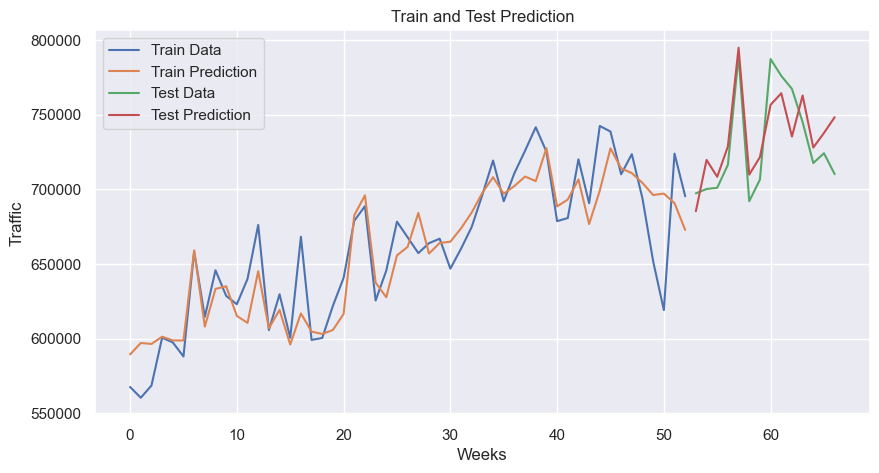

In [8]:
ridge_model = MMMRegression(
    medias=medias_with_more_investment, 
    ).load_model("/Users/marianebando/Documents/Git/MMM-case/models/regression_model_20240819.joblib")

pred_ridge_train = ridge_model.predict(df_train[all_features])
pred_ridge_test = ridge_model.predict(df_test[all_features])
print("Train")
print(report_metrics(df_train["traffic"], pred_ridge_train))
print("Test")   
print(report_metrics(df_test["traffic"], pred_ridge_test))

plot_prediction(df_train["traffic"], df_test["traffic"], pred_ridge_train, pred_ridge_test, fig_size=(10,5))

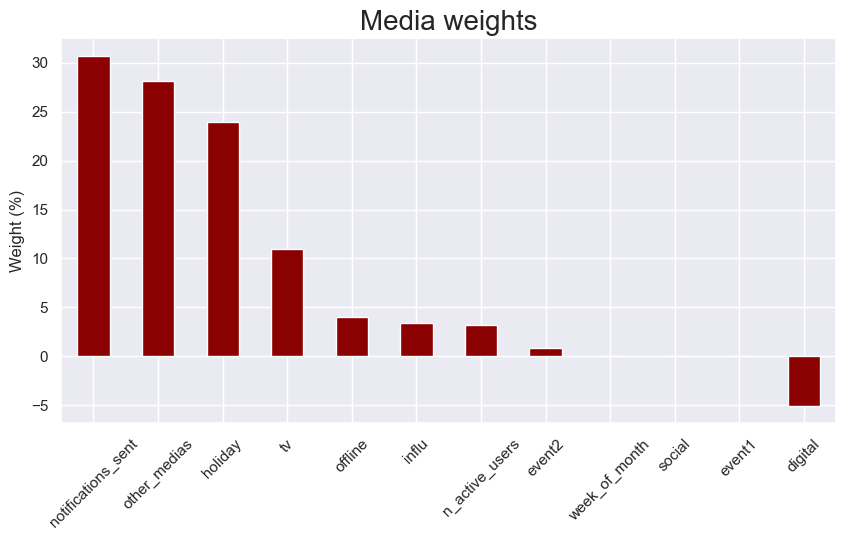

other_medias    0.6789
tv              0.2646
offline         0.0971
influ           0.0825
social         -0.0000
digital        -0.1230
dtype: float64

In [9]:
# get coefficients from ridge_model.model.named_steps["regression"].coef_
weights = {col: float(coef) for col, coef in zip(all_features, ridge_model.model.named_steps["regression"].coef_)}
weights = pd.Series(weights).sort_values(ascending=False)
plot_weights(weights/weights.sum()*100, figsize=(10, 5))

weighted_weights = (weights[medias_with_more_investment]/weights[medias_with_more_investment].sum()).sort_values(ascending=False)
weighted_weights

# Simulando investimento

In [10]:
df_new_media = {}
weeks = 15
investment = 10_000_000
# investment = 200
for media in weighted_weights[weighted_weights>0].index:
    df_new = pd.DataFrame({col: np.zeros(weeks) for col in all_features})
    df_new["n_active_users"] = df_week["n_active_users"].iloc[-1]
    df_new["notifications_sent"] = df_week["notifications_sent"].iloc[-1]
    df_new["week_of_month"] = 2
    df_new[media].iloc[5] = investment
    df_new["pred"] = ridge_model.predict(df_new[all_features])
    total_added_traffic = round(df_new["pred"] - df_new["pred"].iloc[0]).sum()
    print(f'Investment in {media} was: R${investment/1e6}MM and return in traffic was {round(total_added_traffic)} ({total_added_traffic/investment}/real invested)')
    
    df_new_media[media] = df_new

Investment in other_medias was: R$10.0MM and return in traffic was 105363 (0.0105363/real invested)
Investment in tv was: R$10.0MM and return in traffic was 48372 (0.0048372/real invested)
Investment in offline was: R$10.0MM and return in traffic was 13659 (0.0013659/real invested)
Investment in influ was: R$10.0MM and return in traffic was 25758 (0.0025758/real invested)


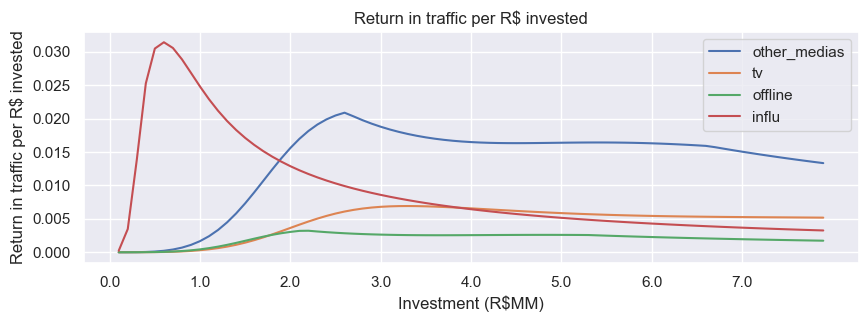

In [11]:
# r = np.arange(0, 2_000_000, 10000)
return_media = {}
weeks = 15
investment = 1_000_000
for media in weighted_weights[weighted_weights>0].index:
    return_by_value = {}
    for investment in range(100_000, 8_000_000, 100_000):
        df_new = pd.DataFrame({col: np.zeros(weeks) for col in all_features})
        df_new["n_active_users"] = df_week["n_active_users"].iloc[-1]
        df_new["notifications_sent"] = df_week["notifications_sent"].iloc[-1]
        df_new["week_of_month"] = 2
        df_new[media].iloc[5] = investment
        df_new["pred"] = ridge_model.predict(df_new[all_features])
        total_added_traffic = round(df_new["pred"] - df_new["pred"].iloc[0]).sum()
        return_by_value[investment] = total_added_traffic/investment # investment/R$100
    return_media[media] = return_by_value

# plot return_media["other_medias"]
fig = plt.figure(figsize=(10,3))
for media in weighted_weights[weighted_weights>0].index:
    pd.Series(return_media[media]).plot(label = str(media))
plt.title("Return in traffic per R$ invested")
plt.legend(loc='upper right')
# add xlabels as 10e6
plt.xticks([i for i in range(0, 8000_000, 1_000_000)], [f"{i/1e6}" for i in range(0, 8_000_000, 1_000_000)])
plt.xlabel("Investment (R$MM)")
plt.ylabel("Return in traffic per R$ invested")
plt.show()